In [1]:
import numpy as np
import pandas as pd 

import os
from matplotlib import pyplot as plt
import cv2
import gc
import tensorflow
from tqdm import tqdm
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.applications import DenseNet121,DenseNet169,DenseNet201

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
x_train1 = np.load("/content/drive/MyDrive/AI/x_train.npy")
y_train1 = np.load("/content/drive/MyDrive/AI/y_train.npy")

In [4]:
from sklearn.model_selection import train_test_split
x_sptrain, x_spval, y_sptrain, y_spval = train_test_split(
    x_train1, y_train1,
    random_state=42
)
print("train-validation splitted ...")

train-validation splitted ...


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.1,
        rotation_range=360,
        horizontal_flip=True,
        vertical_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2
    )


data_generator = create_datagen().flow(x_train1, y_train1,batch_size=32,seed=42, shuffle=True)
print("Image data augmentated ...")

Image data augmentated ...


In [6]:
import tensorflow as tf
import keras.backend as K


In [7]:
gc.collect()

0

In [8]:
densenet = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(256,256,3)
)
resnet = ResNet50(weights='imagenet',
                   include_top=False,
                     input_shape=(256, 256, 3))
vgg19 = VGG19(weights='imagenet',
               include_top=False,
                 input_shape=(256, 256, 3))

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [9]:
print(tf.config.experimental.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
from tensorflow.keras.applications import VGG19
model = Sequential()
#choose the model to use
#model.add(densenet)
#model.add(resnet)
model.add(vgg19)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024,activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))



80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [11]:
gc.collect()

7

In [12]:
import tensorflow as tf
from keras.callbacks import Callback,ModelCheckpoint
from sklearn.metrics import cohen_kappa_score
import json
class KappaMetrics(Callback):
    i=0
    def __init__(self, validation_data):
        super(Callback, self).__init__()
        self.validation_data = validation_data

    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1

        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred,
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"Epoch: {epoch+1} val_kappa: {_val_kappa:.4f}")

        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model. - "+str(KappaMetrics.i))
            model_json = self.model.to_json()
            with open("model_in_json"+str(KappaMetrics.i)+".json", "w") as json_file:
              json.dump(model_json, json_file)
            self.model.save_weights("model_weights"+str(KappaMetrics.i)+".weights.h5")
            KappaMetrics.i+=1
        return



In [13]:
import tensorflow as tf

def f1_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.round(y_pred), tf.float32)

    tp = tf.reduce_sum(y_true * y_pred, axis=0)
    tn = tf.reduce_sum((1 - y_true) * (1 - y_pred), axis=0)
    fp = tf.reduce_sum((1 - y_true) * y_pred, axis=0)
    fn = tf.reduce_sum(y_true * (1 - y_pred), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2 * p * r / (p + r + tf.keras.backend.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return tf.reduce_mean(f1)


In [14]:
x_val = np.load("/content/drive/MyDrive/AI/x_valid.npy")
y_val = np.load("/content/drive/MyDrive/AI/y_valid.npy")
print(x_val.shape)  
print(y_val.shape) 
print(x_train1.shape)
print(y_train1.shape)  


(366, 256, 256, 3)
(366, 5)
(2930, 256, 256, 3)
(2930, 5)


In [15]:
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.00005),
    metrics=['accuracy', f1_metric], 
)
x_val = np.load("/content/drive/MyDrive/AI/x_valid.npy")
y_val = np.load("/content/drive/MyDrive/AI/y_valid.npy")
history = model.fit(
    data_generator,
    steps_per_epoch= x_train1.shape[0] // 32,
    epochs=40,
    validation_data=(x_val, y_val),
    callbacks=[KappaMetrics(validation_data=(x_val, y_val))],
)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step
Epoch: 1 val_kappa: 0.6571
Validation Kappa has improved. Saving model. - 0
91/91 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.9366 - f1_metric: 0.4827 - loss: 0.4375 - val_accuracy: 1.0000 - val_f1_metric: 0.5630 - val_loss: 0.2197
Epoch 2/40
 1/91 ━━━━━━━━━━━━━━━━━━━━ 1:00 676ms/step - accuracy: 0.9688 - f1_metric: 0.7343 - loss: 0.1802

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step
Epoch: 2 val_kappa: 0.7156
Validation Kappa has improved. Saving model. - 1
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.9688 - f1_metric: 0.7343 - loss: 0.1802 - val_accuracy: 0.9945 - val_f1_metric: 0.6026 - val_loss: 0.1990
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step
Epoch: 3 val_kappa: 0.5267
91/91 ━━━━━━━━━━━━━━━━━━━━ 110s 856ms/step - accuracy: 0.8913 - f1_metric: 0.6088 - loss: 0.2180 - val_accuracy: 0.9536 - val_f1_metric: 0.4659 - val_loss: 0.3175
Epoch 4/40
 1/91 ━━━━━━━━━━━━━━━━━━━━ 1:00 676ms/step - accuracy: 0.9375 - f1_metric: 0.5247 - loss: 0.3313

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step
Epoch: 4 val_kappa: 0.5414
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.9375 - f1_metric: 0.5247 - loss: 0.3313 - val_accuracy: 0.9617 - val_f1_metric: 0.4729 - val_loss: 0.2963
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step
Epoch: 5 val_kappa: 0.5749
91/91 ━━━━━━━━━━━━━━━━━━━━ 132s 795ms/step - accuracy: 0.8558 - f1_metric: 0.6214 - loss: 0.1807 - val_accuracy: 0.9645 - val_f1_metric: 0.4985 - val_loss: 0.3507
Epoch 6/40
 1/91 ━━━━━━━━━━━━━━━━━━━━ 1:00 676ms/step - accuracy: 0.8438 - f1_metric: 0.5929 - loss: 0.2726

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step
Epoch: 6 val_kappa: 0.6664
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.8438 - f1_metric: 0.5929 - loss: 0.2726 - val_accuracy: 0.9399 - val_f1_metric: 0.5503 - val_loss: 0.2580
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step
Epoch: 7 val_kappa: 0.6862
91/91 ━━━━━━━━━━━━━━━━━━━━ 135s 787ms/step - accuracy: 0.8421 - f1_metric: 0.6694 - loss: 0.1734 - val_accuracy: 0.9235 - val_f1_metric: 0.5468 - val_loss: 0.2478
Epoch 8/40
 1/91 ━━━━━━━━━━━━━━━━━━━━ 1:00 676ms/step - accuracy: 0.9062 - f1_metric: 0.5654 - loss: 0.1568

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step
Epoch: 8 val_kappa: 0.7425
Validation Kappa has improved. Saving model. - 2
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9062 - f1_metric: 0.5654 - loss: 0.1568 - val_accuracy: 0.8798 - val_f1_metric: 0.5716 - val_loss: 0.2090
Epoch 9/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step
Epoch: 9 val_kappa: 0.8550
Validation Kappa has improved. Saving model. - 3
91/91 ━━━━━━━━━━━━━━━━━━━━ 76s 793ms/step - accuracy: 0.7830 - f1_metric: 0.6789 - loss: 0.1540 - val_accuracy: 0.8169 - val_f1_metric: 0.7514 - val_loss: 0.1616
Epoch 10/40
 1/91 ━━━━━━━━━━━━━━━━━━━━ 1:01 682ms/step - accuracy: 0.8438 - f1_metric: 0.7226 - loss: 0.1458

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step
Epoch: 10 val_kappa: 0.8471
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8438 - f1_metric: 0.7226 - loss: 0.1458 - val_accuracy: 0.8333 - val_f1_metric: 0.7420 - val_loss: 0.1695
Epoch 11/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step
Epoch: 11 val_kappa: 0.7782
91/91 ━━━━━━━━━━━━━━━━━━━━ 76s 790ms/step - accuracy: 0.7978 - f1_metric: 0.6813 - loss: 0.1487 - val_accuracy: 0.8470 - val_f1_metric: 0.6759 - val_loss: 0.2083
Epoch 12/40
 1/91 ━━━━━━━━━━━━━━━━━━━━ 1:01 679ms/step - accuracy: 0.9688 - f1_metric: 0.6390 - loss: 0.2263

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step
Epoch: 12 val_kappa: 0.7806
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.9688 - f1_metric: 0.6390 - loss: 0.2263 - val_accuracy: 0.8415 - val_f1_metric: 0.6571 - val_loss: 0.1939
Epoch 13/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step
Epoch: 13 val_kappa: 0.8455
91/91 ━━━━━━━━━━━━━━━━━━━━ 75s 791ms/step - accuracy: 0.8204 - f1_metric: 0.7163 - loss: 0.1472 - val_accuracy: 0.7978 - val_f1_metric: 0.6940 - val_loss: 0.1451
Epoch 14/40
 1/91 ━━━━━━━━━━━━━━━━━━━━ 1:00 677ms/step - accuracy: 0.9062 - f1_metric: 0.6921 - loss: 0.0892

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step
Epoch: 14 val_kappa: 0.8708
Validation Kappa has improved. Saving model. - 4
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9062 - f1_metric: 0.6921 - loss: 0.0892 - val_accuracy: 0.7623 - val_f1_metric: 0.7143 - val_loss: 0.1407
Epoch 15/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step
Epoch: 15 val_kappa: 0.8753
Validation Kappa has improved. Saving model. - 5
91/91 ━━━━━━━━━━━━━━━━━━━━ 76s 796ms/step - accuracy: 0.8157 - f1_metric: 0.7207 - loss: 0.1386 - val_accuracy: 0.8005 - val_f1_metric: 0.8062 - val_loss: 0.1665
Epoch 16/40
 1/91 ━━━━━━━━━━━━━━━━━━━━ 1:00 676ms/step - accuracy: 0.9062 - f1_metric: 0.6618 - loss: 0.1425

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step
Epoch: 16 val_kappa: 0.8738
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9062 - f1_metric: 0.6618 - loss: 0.1425 - val_accuracy: 0.7705 - val_f1_metric: 0.8164 - val_loss: 0.1656
Epoch 17/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step
Epoch: 17 val_kappa: 0.8753
Validation Kappa has improved. Saving model. - 6
91/91 ━━━━━━━━━━━━━━━━━━━━ 78s 794ms/step - accuracy: 0.7642 - f1_metric: 0.7411 - loss: 0.1349 - val_accuracy: 0.7596 - val_f1_metric: 0.8090 - val_loss: 0.1509
Epoch 18/40
 1/91 ━━━━━━━━━━━━━━━━━━━━ 58s 654ms/step - accuracy: 0.9062 - f1_metric: 0.7267 - loss: 0.1190

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step
Epoch: 18 val_kappa: 0.8645
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.9062 - f1_metric: 0.7267 - loss: 0.1190 - val_accuracy: 0.8005 - val_f1_metric: 0.8081 - val_loss: 0.1633
Epoch 19/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step
Epoch: 19 val_kappa: 0.9002
Validation Kappa has improved. Saving model. - 7
91/91 ━━━━━━━━━━━━━━━━━━━━ 75s 796ms/step - accuracy: 0.7838 - f1_metric: 0.7604 - loss: 0.1177 - val_accuracy: 0.6721 - val_f1_metric: 0.8331 - val_loss: 0.1297
Epoch 20/40
 1/91 ━━━━━━━━━━━━━━━━━━━━ 1:01 678ms/step - accuracy: 0.7188 - f1_metric: 0.8936 - loss: 0.1041

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step
Epoch: 20 val_kappa: 0.8950
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.7188 - f1_metric: 0.8936 - loss: 0.1041 - val_accuracy: 0.6967 - val_f1_metric: 0.8356 - val_loss: 0.1320
Epoch 21/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step
Epoch: 21 val_kappa: 0.8766
91/91 ━━━━━━━━━━━━━━━━━━━━ 76s 795ms/step - accuracy: 0.7831 - f1_metric: 0.7664 - loss: 0.1239 - val_accuracy: 0.6612 - val_f1_metric: 0.7767 - val_loss: 0.1319
Epoch 22/40
 1/91 ━━━━━━━━━━━━━━━━━━━━ 1:01 678ms/step - accuracy: 0.6562 - f1_metric: 0.5507 - loss: 0.2692

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step
Epoch: 22 val_kappa: 0.8918
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.6562 - f1_metric: 0.5507 - loss: 0.2692 - val_accuracy: 0.6557 - val_f1_metric: 0.7880 - val_loss: 0.1295
Epoch 23/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step
Epoch: 23 val_kappa: 0.9002
91/91 ━━━━━━━━━━━━━━━━━━━━ 76s 785ms/step - accuracy: 0.7739 - f1_metric: 0.7599 - loss: 0.1240 - val_accuracy: 0.7295 - val_f1_metric: 0.8241 - val_loss: 0.1370
Epoch 24/40
 1/91 ━━━━━━━━━━━━━━━━━━━━ 1:01 683ms/step - accuracy: 0.7500 - f1_metric: 0.6169 - loss: 0.2429

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step
Epoch: 24 val_kappa: 0.9021
Validation Kappa has improved. Saving model. - 8
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.7500 - f1_metric: 0.6169 - loss: 0.2429 - val_accuracy: 0.7186 - val_f1_metric: 0.8237 - val_loss: 0.1365
Epoch 25/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step
Epoch: 25 val_kappa: 0.8898
91/91 ━━━━━━━━━━━━━━━━━━━━ 75s 787ms/step - accuracy: 0.8081 - f1_metric: 0.7993 - loss: 0.1159 - val_accuracy: 0.6940 - val_f1_metric: 0.8066 - val_loss: 0.1315
Epoch 26/40
 1/91 ━━━━━━━━━━━━━━━━━━━━ 1:00 675ms/step - accuracy: 0.7188 - f1_metric: 0.8333 - loss: 0.1886

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step
Epoch: 26 val_kappa: 0.8811
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.7188 - f1_metric: 0.8333 - loss: 0.1886 - val_accuracy: 0.7104 - val_f1_metric: 0.7844 - val_loss: 0.1347
Epoch 27/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step
Epoch: 27 val_kappa: 0.8684
91/91 ━━━━━━━━━━━━━━━━━━━━ 75s 790ms/step - accuracy: 0.7940 - f1_metric: 0.7752 - loss: 0.1093 - val_accuracy: 0.5464 - val_f1_metric: 0.7265 - val_loss: 0.1329
Epoch 28/40
 1/91 ━━━━━━━━━━━━━━━━━━━━ 1:00 677ms/step - accuracy: 0.5938 - f1_metric: 0.5733 - loss: 0.1230

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step
Epoch: 28 val_kappa: 0.8673
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.5938 - f1_metric: 0.5733 - loss: 0.1230 - val_accuracy: 0.5929 - val_f1_metric: 0.7111 - val_loss: 0.1271
Epoch 29/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step
Epoch: 29 val_kappa: 0.8957
91/91 ━━━━━━━━━━━━━━━━━━━━ 78s 788ms/step - accuracy: 0.7535 - f1_metric: 0.7490 - loss: 0.1300 - val_accuracy: 0.6585 - val_f1_metric: 0.7914 - val_loss: 0.1246
Epoch 30/40
 1/91 ━━━━━━━━━━━━━━━━━━━━ 1:00 677ms/step - accuracy: 0.8750 - f1_metric: 0.8400 - loss: 0.0788

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step
Epoch: 30 val_kappa: 0.8987
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8750 - f1_metric: 0.8400 - loss: 0.0788 - val_accuracy: 0.7022 - val_f1_metric: 0.8091 - val_loss: 0.1243
Epoch 31/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step
Epoch: 31 val_kappa: 0.9008
91/91 ━━━━━━━━━━━━━━━━━━━━ 75s 785ms/step - accuracy: 0.7921 - f1_metric: 0.7884 - loss: 0.1175 - val_accuracy: 0.6175 - val_f1_metric: 0.8135 - val_loss: 0.1211
Epoch 32/40
 1/91 ━━━━━━━━━━━━━━━━━━━━ 1:01 679ms/step - accuracy: 0.7500 - f1_metric: 0.9301 - loss: 0.0930

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step
Epoch: 32 val_kappa: 0.9022
Validation Kappa has improved. Saving model. - 9
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.7500 - f1_metric: 0.9301 - loss: 0.0930 - val_accuracy: 0.6120 - val_f1_metric: 0.8136 - val_loss: 0.1228
Epoch 33/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step
Epoch: 33 val_kappa: 0.8583
91/91 ━━━━━━━━━━━━━━━━━━━━ 135s 798ms/step - accuracy: 0.7928 - f1_metric: 0.7887 - loss: 0.1099 - val_accuracy: 0.8142 - val_f1_metric: 0.8004 - val_loss: 0.1547
Epoch 34/40
 1/91 ━━━━━━━━━━━━━━━━━━━━ 1:00 672ms/step - accuracy: 0.9062 - f1_metric: 0.8381 - loss: 0.0721

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step
Epoch: 34 val_kappa: 0.8597
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9062 - f1_metric: 0.8381 - loss: 0.0721 - val_accuracy: 0.8169 - val_f1_metric: 0.7996 - val_loss: 0.1535
Epoch 35/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step
Epoch: 35 val_kappa: 0.8891
91/91 ━━━━━━━━━━━━━━━━━━━━ 75s 787ms/step - accuracy: 0.7813 - f1_metric: 0.7874 - loss: 0.1135 - val_accuracy: 0.7814 - val_f1_metric: 0.8242 - val_loss: 0.1271
Epoch 36/40
 1/91 ━━━━━━━━━━━━━━━━━━━━ 1:01 681ms/step - accuracy: 0.9375 - f1_metric: 0.8522 - loss: 0.0887

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step
Epoch: 36 val_kappa: 0.8984
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.9375 - f1_metric: 0.8522 - loss: 0.0887 - val_accuracy: 0.7623 - val_f1_metric: 0.8328 - val_loss: 0.1237
Epoch 37/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step
Epoch: 37 val_kappa: 0.9025
Validation Kappa has improved. Saving model. - 10
91/91 ━━━━━━━━━━━━━━━━━━━━ 77s 800ms/step - accuracy: 0.8048 - f1_metric: 0.8027 - loss: 0.1137 - val_accuracy: 0.6803 - val_f1_metric: 0.8373 - val_loss: 0.1285
Epoch 38/40
 1/91 ━━━━━━━━━━━━━━━━━━━━ 1:00 676ms/step - accuracy: 0.5938 - f1_metric: 0.8378 - loss: 0.1834

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step
Epoch: 38 val_kappa: 0.8974
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.5938 - f1_metric: 0.8378 - loss: 0.1834 - val_accuracy: 0.6858 - val_f1_metric: 0.8278 - val_loss: 0.1282
Epoch 39/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step
Epoch: 39 val_kappa: 0.9139
Validation Kappa has improved. Saving model. - 11
91/91 ━━━━━━━━━━━━━━━━━━━━ 82s 864ms/step - accuracy: 0.7706 - f1_metric: 0.7964 - loss: 0.1058 - val_accuracy: 0.6831 - val_f1_metric: 0.8494 - val_loss: 0.1190
Epoch 40/40
 1/91 ━━━━━━━━━━━━━━━━━━━━ 1:04 718ms/step - accuracy: 0.9062 - f1_metric: 0.8797 - loss: 0.0710

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step
Epoch: 40 val_kappa: 0.9111
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9062 - f1_metric: 0.8797 - loss: 0.0710 - val_accuracy: 0.6995 - val_f1_metric: 0.8513 - val_loss: 0.1242


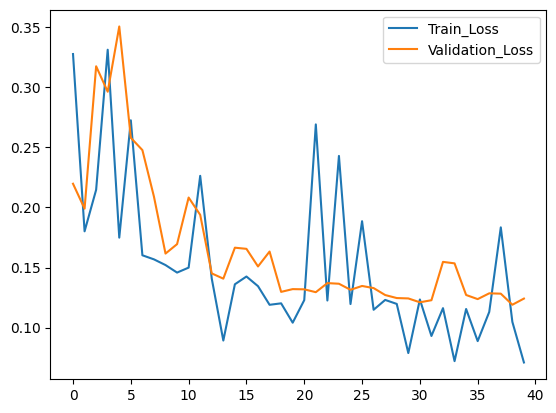

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train_Loss','Validation_Loss'])

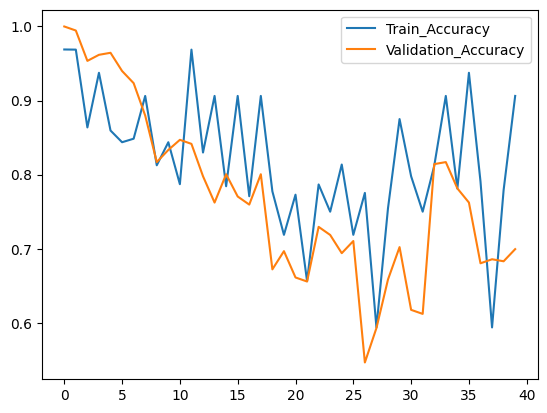

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train_Accuracy','Validation_Accuracy'])

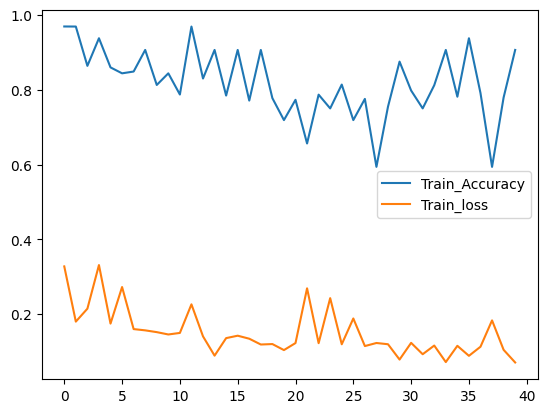

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.legend(['Train_Accuracy','Train_loss'])

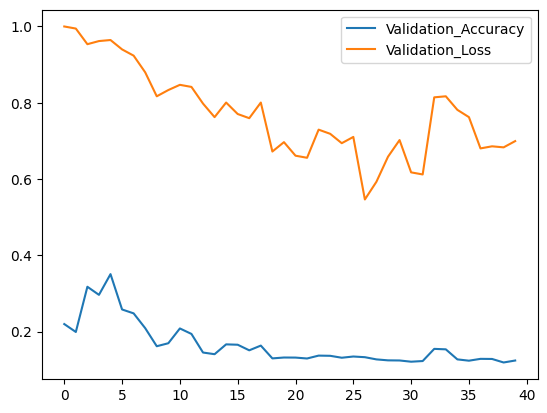

In [19]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Validation_Accuracy','Validation_Loss'])